In [44]:
# Importando as bibliotecas e módulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import metrics
import eli5 # Biblioteca que depurar algoritmos classificadores
#from asd import dataset, utilits, metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import sklearn.metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, cross_val_score
from eli5.sklearn import PermutationImportance # Metodo para calcular feature importance de algoritmo 'caixa preta'
from eli5.permutation_importance import get_score_importances # Método que retorna as pontuações das caracteristicas
import seaborn as sns
import warnings

#from sklearn.inspection import permutation_importance


In [45]:
np.random.seed(0)
warnings.filterwarnings('ignore')

In [46]:
# Criando dataframe
#df = dataset.autism()
# Tratamento dos dados
#X,Y = dataset.basicResourceEngineering(df)

In [47]:
def basicResourceEngineering(data):
    # Input: Dataset
    # Output: Independent and Dependent variable, respectively.
    # The independent variables are filtered and the dependent
    # variable recoded.
    attributes = ["A{}_Score".format(n) for n in range(1, 11)]
    data["Class/ASD"] = data["Class/ASD"].replace(
        {"NO": 0, "YES": 1}
    )
    return data[attributes], data["Class/ASD"]

# Criando o dataframe
df = pd.read_csv('dataset.csv')
X,Y = basicResourceEngineering(df)
df.head()

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,0,0,1,1,0,1,0,...,m,Others,no,no,Jordan,no,5,4-11 years,Parent,0
1,2,1,1,0,0,1,1,0,1,0,...,m,Middle Eastern,no,no,Jordan,no,5,4-11 years,Parent,0
2,3,1,1,0,0,0,1,1,1,0,...,m,?,no,no,Jordan,yes,5,4-11 years,?,0
3,4,0,1,0,0,1,1,0,0,0,...,f,?,yes,no,Jordan,no,4,4-11 years,?,0
4,5,1,1,1,1,1,1,1,1,1,...,m,Others,yes,no,United States,no,10,4-11 years,Parent,1


In [48]:
# Variáveis Independentes
X.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
0,1,1,0,0,1,1,0,1,0,0
1,1,1,0,0,1,1,0,1,0,0
2,1,1,0,0,0,1,1,1,0,0
3,0,1,0,0,1,1,0,0,0,1
4,1,1,1,1,1,1,1,1,1,1


In [49]:
# Variável Dependente
Y.head()

0    0
1    0
2    0
3    0
4    1
Name: Class/ASD, dtype: int64

In [50]:
# Selecionando colunas com os traços comportamentais.
columns = ['A{}_Score'.format(i) for i in range(1,11)]

columns

['A1_Score',
 'A2_Score',
 'A3_Score',
 'A4_Score',
 'A5_Score',
 'A6_Score',
 'A7_Score',
 'A8_Score',
 'A9_Score',
 'A10_Score']

# KNN - K Nearest Neighbors

**Funcionamento:** O KNN é um algoritmo supervisionado que pode ser construído tanto para Classificação quanto para Regressão. Seu funcionamento é bem simples:

**1.** Calcula-se a distância entre a nova observação e as demais;

**2.** Ordena-se todas as distâncias de forma Crescente ou Decrescente, dependendo da aplicação;

**3.** Retorna as K melhores observações que tiveram as melhores distâncias.


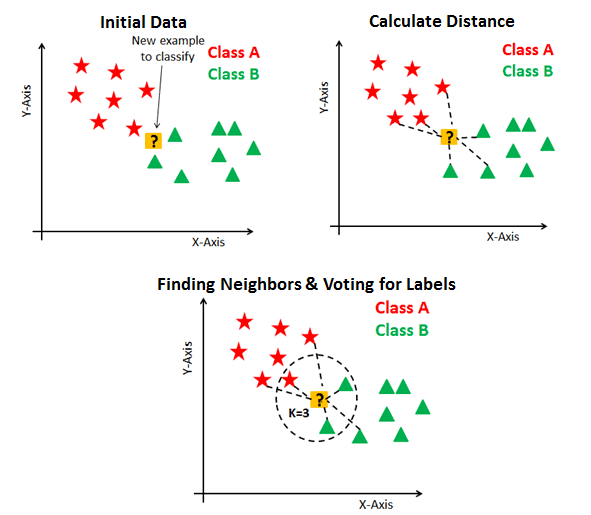

In [51]:
# Modelo
knn = KNeighborsClassifier()
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [52]:
# Seleção do Melhor K e melhor Distância
# A formulado cálculo da distância é Minkowski, ou seja:

# P = 2 -> Cálculo da distância Euclidiana
# P = 1 - > Calculo da distância de Manhatan

kGroup = [1,2,3,4,5,6,7,8,9,10]
leafGroup = [1,2,3,4,5,6]

In [53]:
# Validação cruzada
def crossValidation(model,X,Y,splits):
    metricas = []
    i = 0
    skf = StratifiedKFold(n_splits = splits, shuffle = True, random_state = 1)
    # Separando as bases de treino e teste
    for train,test in skf.split(X,Y):
        # Dicionaro de treino
        train_x, test_x = X.iloc[train], X.iloc[test]
        train_y, test_y = Y.iloc[train], Y.iloc[test]
        aux = model.fit(train_x,train_y)
        rst = aux.predict(test_x)
        metricas.append(metrics.classification_report(test_y, rst))
        i+=1
        
    return metricas

In [54]:
optimizerParams = {'k':[],'leaf':[],'accuracy':[],'precision':[],'recall':[],'f1':[]}
splits = 5
# Otimização de parâmetros
for k in kGroup:
    for leaf in leafGroup:
        knn = KNeighborsClassifier(n_neighbors = k, leaf_size = leaf)
        metricas = crossValidation(knn,X,Y,splits)        
        optimizerParams['k'].append(k)
        optimizerParams['leaf'].append(leaf)
        optimizerParams['accuracy'].append(np.mean(np.array([metricas[x]['accuracy'] for x in range(5)])))
        optimizerParams['precision'].append(np.mean(np.array([metricas[x]['precision'] for x in range(5)])))
        optimizerParams['recall'].append(np.mean(np.array([metricas[x]['recall'] for x in range(5)])))
        optimizerParams['f1'].append(np.mean(np.array([metricas[x]['f1'] for x in range(5)])))
        
Optimizer = pd.DataFrame.from_dict(optimizerParams)


In [55]:
Optimizer

,k,leaf,accuracy,precision,recall,f1
0,1,1,0.928304,0.942449,0.927312,0.933240
1,1,2,0.904984,0.936190,0.914194,0.923389
2,1,3,0.904984,0.936190,0.914194,0.923389
3,1,4,0.928939,0.937005,0.927312,0.930384
4,1,5,0.928939,0.937005,0.927312,0.930384
5,1,6,0.928939,0.937005,0.927312,0.930384
6,2,1,1.028141,0.919862,0.980000,0.948792
7,2,2,1.028459,0.914871,0.980000,0.946014
8,2,3,1.028459,0.914871,0.980000,0.946014
9,2,4,1.028459,0.914871,0.980000,0.946014


In [56]:
for col in ["accuracy","precision","recall","f1"]:
    print("Combinação com melhor {}: k={} e leaf_size={} --- Score do Grupo: {}".format(col,Optimizer[Optimizer[col] == Optimizer[col].max()]["k"].unique(),Optimizer[Optimizer[col] == Optimizer[col].max()]["leaf"].unique(),Optimizer[col].max()))

Combinação com melhor accuracy: k=[2] e leaf_size=[2 3 4 5 6] --- Score do Grupo: 1.0284587813620072
Combinação com melhor precision: k=[9] e leaf_size=[1 2 3 4 5 6] --- Score do Grupo: 1.0
Combinação com melhor recall: k=[2] e leaf_size=[1 2 3 4 5 6] --- Score do Grupo: 0.9800000000000001
Combinação com melhor f1: k=[2] e leaf_size=[1] --- Score do Grupo: 0.9487916866023687


# SVM - Support Vector Machine

**Funcionamento:** O SVM é um modelo supervisionado de algoritmos de aprendizagem de máquina que tem como o objetivo uma região de separação que separe as duas classes de forma a formar uma melhor "margem de segurança". O tamanho dessa "margem" pode ser controlada alterando o valor de uma constante C, que ela basicamente permite a grosso modo que existam observações que "burlem" essa margem.

**Obs:** Quanto menor o valor de C menor é o tamanho da "margem", quanto maior o valor de C maior é a "margem".

**Exemplo de um SVM Linear**

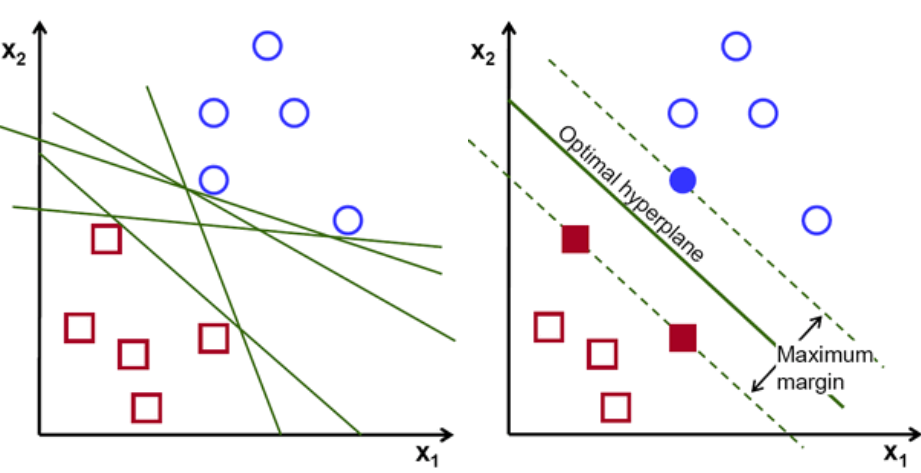

In [57]:
svm = SVC(kernel= 'linear')
svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [58]:
# Selecionando o melhor valor de C

C = [0.01,0.1,1,10,50,100]
kernels = ["linear","poly","rbf","sigmoid"]

In [59]:
optimizerParams = {'kernel':[],'C':[],'accuracy':[],'precision':[],'recall':[],'f1':[]}
splits = 5
# Otimização de parâmetros
for kernel in kernels:
    for c in C:
        svm = SVC(kernel= kernel, C = c)
        metricas = crossValidation(svm,X,Y,splits)
        optimizerParams['kernel'].append(kernel)
        optimizerParams['C'].append(c)
        optimizerParams['accuracy'].append(np.mean(np.array([metricas[x]['accuracy'] for x in range(5)])))
        optimizerParams['precision'].append(np.mean(np.array([metricas[x]['precision'] for x in range(5)])))
        optimizerParams['recall'].append(np.mean(np.array([metricas[x]['recall'] for x in range(5)])))
        optimizerParams['f1'].append(np.mean(np.array([metricas[x]['f1'] for x in range(5)])))
        
Optimizer = pd.DataFrame.from_dict(optimizerParams)

In [60]:
Optimizer

,kernel,C,accuracy,precision,recall,f1
0,linear,0.01,0.942738,0.978519,0.933763,0.955316
1,linear,0.10,1.015606,0.987500,0.973333,0.979632
2,linear,1.00,1.070936,1.000000,1.000000,1.000000
3,linear,10.00,1.070936,1.000000,1.000000,1.000000
4,linear,50.00,1.070936,1.000000,1.000000,1.000000
5,linear,100.00,1.070936,1.000000,1.000000,1.000000
6,poly,0.01,1.035468,0.517126,1.000000,0.681718
7,poly,0.10,1.056178,0.802608,1.000000,0.889494
8,poly,1.00,1.068998,0.974597,1.000000,0.986991
9,poly,10.00,1.070936,1.000000,1.000000,1.000000


# Comparação dos Modelos

In [61]:
def learning_curve(model, name_model, X, Y, scoring, train_data_size):
    """
    Function responsible for creating a learning curve of a model.
    ---------------------------------------
    Input:
        model -> Parameter responsible for receiving the model to be tested.
                 Note: It is important to note that seram uses only models
                 from the Sklearn library. (For now!!!!)
        name_model -> Parameter that receives or Name of the model to be
                      displayed in the graph.
        X -> Dependent Variable.
        Y -> Independent Variable.
        scoring -> Type of metric used for graph construction.
                   Currently only supported:
                   'precision', 'precision', 'recall' and 'f1'.
        train_data_size -> Size of training data.
    ---------------------------------------
    Output:
        The output is a plot of learning curve graphs.
    """

    resultTrain = []
    resultValid = []
    X_train, X_valid, Y_train, Y_valid = train_test_split(
        X, Y, train_size=train_data_size, random_state=42
    )
    Size = np.linspace(0.05, 1.0, 50).tolist()

    for size in Size:
        X_trainTemp = X_train.iloc[: int(X.shape[0] * size), :]
        Y_trainTemp = Y_train.iloc[: int(X.shape[0] * size)]
        aux = model.fit(X_trainTemp, Y_trainTemp)
        rstTreino = aux.predict(X_trainTemp)
        rstValid = aux.predict(X_valid)
        resultTrain.append(
            metrics.classification_report(Y_trainTemp, rstTreino)[scoring]
        )
        resultValid.append(
            metrics.classification_report(Y_valid, rstValid)[scoring]
        )

    plt.plot(
        Size,
        resultTrain,
        "--",
        color="#111111",
        label="Desempenho Treino"
    )
    plt.plot(
        Size,
        resultValid,
        color="#111111",
        label="Desempenho Validação"
    )

    plt.title("Curva de Aprendizagem - Modelo {}".format(name_model))
    plt.xlabel("Tamanho dos Dados de Treino(%)"), plt.ylabel(
        "{} Score".format(scoring)
    ), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

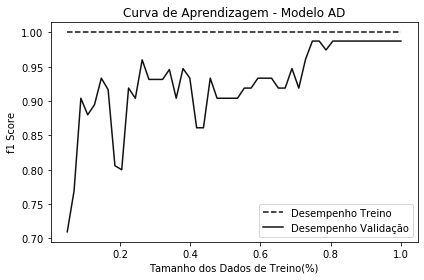

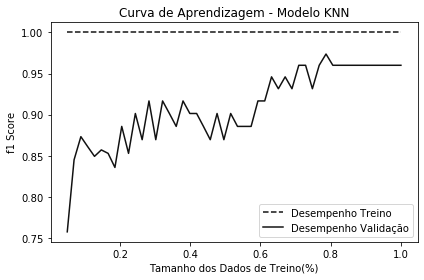

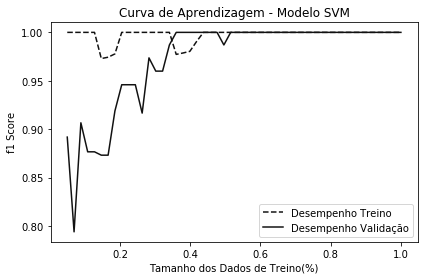

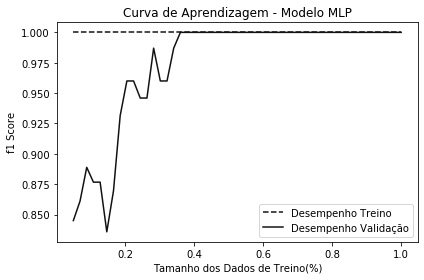

In [108]:
# Modelos
# Se quiser testar mais modelos para ver a curva de aprendizagem, basta:
# model.append(("nome do modelo",model sklearn))
models = []
models.append(("AD",DecisionTreeClassifier(random_state=1)))
models.append(("KNN",KNeighborsClassifier(n_neighbors=1, leaf_size=4)))
models.append(("SVM",SVC(kernel='linear')))
models.append(("MLP",MLPClassifier(solver='lbfgs',
                          alpha = 0.1,
                          hidden_layer_sizes=(20),
                          random_state=1,
                          max_iter=200)))

for model in models:
    learning_curve(model[1], model[0], X, Y, 'f1', 0.8)


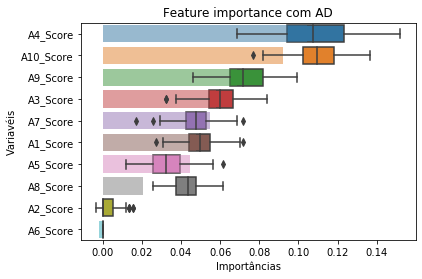

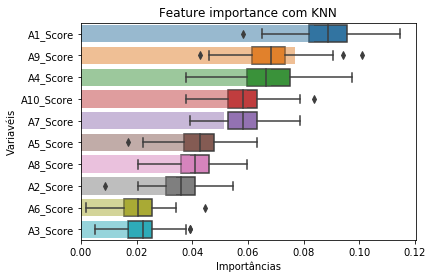

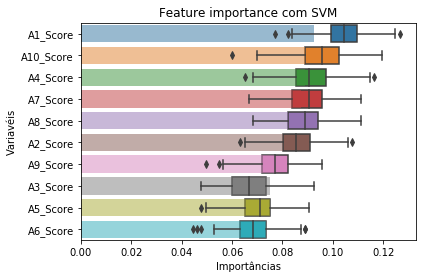

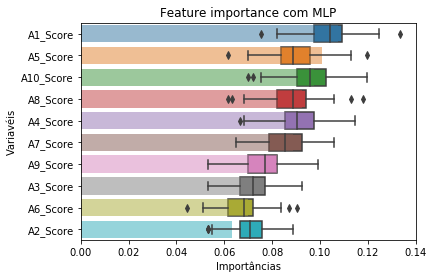

In [119]:
# Modelos
# Se quiser testar mais modelos para ver a curva de aprendizagem, basta:
# model.append(("nome do modelo",model sklearn))
from sklearn.tree import DecisionTreeClassifier
models = []

models.append(("AD",DecisionTreeClassifier(max_depth=100,
                                           splitter='random',
                                           min_samples_leaf=2)))
models.append(("KNN",KNeighborsClassifier(n_neighbors=1,
                                          leaf_size=4)))#lista de tuplas
models.append(("SVM",SVC(kernel='linear',
                         random_state=1)))
models.append(("MLP",MLPClassifier(solver='lbfgs',
                          alpha = 0.1,
                          hidden_layer_sizes=(20),
                          random_state=1,
                          max_iter=150)))


def get_feature_importance(model,X,Y,iterations):
    x_train,x_test,y_train,y_test = train_test_split(X,Y,
                                                 test_size = 0.4,
                                                 random_state = 40)

    for i in range(0,iterations):
        test1 = model[1].fit(x_train,y_train)
        perm = PermutationImportance(model[1]).fit(x_test, y_test)
        to_graph = eli5.explain_weights(perm,feature_names=columns)
        df_feature_importance = eli5.formatters.format_as_dataframe(to_graph)
        
        df_feature_importance['id'] = [int(x.split('_')[0][1:]) for x in df_feature_importance['feature']]
        df_feature_importance = df_feature_importance.sort_values(by=['id'],ascending=True).reset_index()
        df_feature_importance2 = df_feature_importance[['weight','feature','std']]
        
        
        if(i==0):
            df1 = pd.DataFrame()
            df2 = pd.DataFrame()
            df1 = df_feature_importance2.copy()
            df2 = df_feature_importance2.copy()
            #df2['w_p'] = df2['weight']
            #df2['w_l'] = df2['weight']
        else:
            df1 = df1.append(df_feature_importance2,ignore_index = True)
            df2['weight'] = df_feature_importance2['weight']
            #df2['w_p'] = df_feature_importance2['weight']+df_feature_importance2['std']
            #df2['w_l'] = df_feature_importance2['weight']-df_feature_importance2['std']
    
    
    
    df1 = df1.sort_values(by=['weight'],ascending=False).reset_index()
    df2 = df2.sort_values(by=['weight'],ascending=False).reset_index()
    
    #return df2

    #plot to graph
    plt.title("Feature importance com {}".format(model[0]))
    sns.boxplot(x='weight',y='feature',data=df1,boxprops=dict(alpha=1))
    sns.barplot(x=df2['weight'],y=df2['feature'],alpha=0.5)
    plt.ylabel("Variavéis")
    plt.xlabel("Importâncias")
    plt.show()

for model in models:
    get_feature_importance(model,X,Y,200)